# Lab 2

In [1]:
import os
import sys
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [2]:
import math
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as pyplot
from sklearn.model_selection import train_test_split
from bs4 import BeautifulSoup
import pickle

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from tensorflow.keras import layers
from keras.layers import Embedding, LSTM, Dense, Dropout, Dense, Input
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Layer, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical, plot_model

import transformers
from transformers import AutoTokenizer, TFBertModel

In [3]:
print("Tensorflow version: ", tf.__version__)
print("Keras Version: ", keras.__version__)
print("System Version: ", sys.version)

Tensorflow version:  2.9.2
Keras Version:  2.9.0
System Version:  3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]


# Tensfor Flow Setup

In [4]:
from tensorflow.python.client import device_lib

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

tf.debugging.set_log_device_placement(False)
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")

1 Physical GPUs, 1 Logical GPUs


In [5]:
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

# Load ConceptNet Embedding

In [5]:
EMBEDDING_LOCATIONS = {
    "NUMBER_BATCH": "/notebooks/data/embeddings/numberBatch/numberbatch-en-17.04b.txt"
}

In [6]:
# *************************************************************************************************************************************************
# Robyn Speer (2017) How to make a racist AI without really trying [source code]. https://blog.conceptnet.io/posts/2017/how-to-make-a-racist-ai-without-really-trying/
# *************************************************************************************************************************************************
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

In [ ]:
%%time 
number_batch_embedding = load_embeddings(EMBEDDING_LOCATIONS["NUMBER_BATCH"])
number_batch_embedding.shape

CPU times: user 20 s, sys: 986 ms, total: 21 s
Wall time: 26.9 s


(418081, 300)

In [ ]:
# Defines an embedding keras layer
# embedding size : the dimention of the embedding of each word
# embedding_matrix : embedding matrix to utilize
# max_art_length : Maximum and Minumum number of words

def define_embedding_layer(embedding_size, embedding_matrix, max_art_length):
    return Embedding(
        embedding_matrix.shape[0],
        embedding_size,
        weights=[embedding_matrix],
        input_length=max_art_length,
        trainable=False
    )

# Load Dataset

## IMDB

In [6]:
# https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
base_data = pd.read_csv("/notebooks/dataset/imbd_50000/IMDB_Dataset.csv")
df = base_data.copy()
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [7]:
df.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


#### Do we have the same number of elments in positive and negative ?

<AxesSubplot: xlabel='sentiment', ylabel='count'>

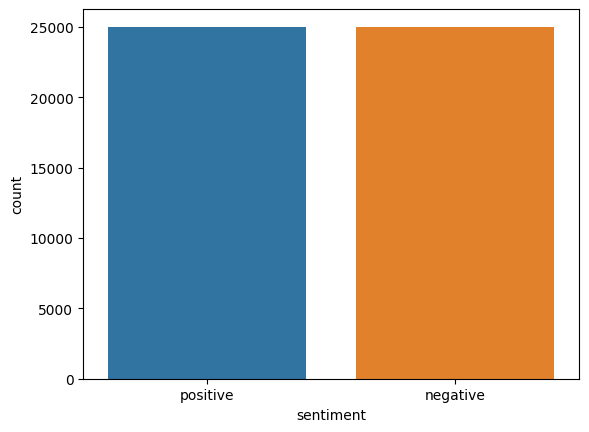

In [9]:
sns.countplot(df, x='sentiment')

It seems we have the same number of instances for each class thus stratifying wouldn't be necessary and an 80/20 split should be sufficient enought. 

#### Sentences Length Distribution ?

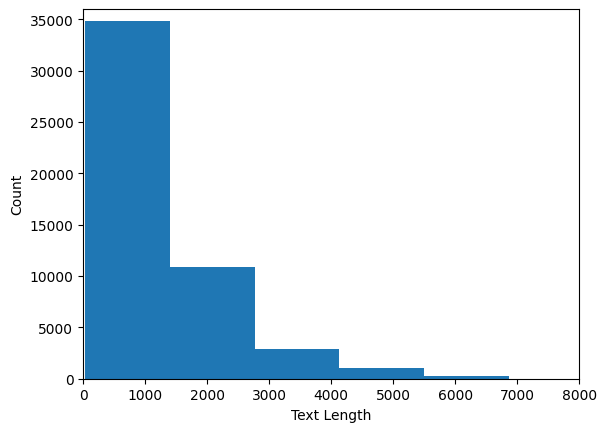

In [10]:
text_lens = df['review'].str.len()
pyplot.hist(text_lens)
pyplot.axis([0,8000,0,36000])
pyplot.xlabel('Text Length')
pyplot.ylabel('Count')
pyplot.show()

In [11]:
print("Mean : " + str(text_lens.mean()))
print("Standard Deviation: " + str(text_lens.std()))

Mean : 1309.43102
Standard Deviation: 989.7280144123484


I think it would be safe to go with ~ 1500

In [12]:
df['sentiment'] = df['sentiment'].astype('category')
df['sentiment'] = df['sentiment'].cat.codes

In [13]:
MAX_ART_LEN = 1500
NUM_CLASSES = 1

### Text Clean UP

#### Need to clean up HTML

In [14]:
print("Sample: ")
df.review[1000]

Sample: 


"This movie is awful, I can't even be bothered to write a review on this garbage! All i will say it is one of the most boring films I've ever seen.<br /><br />And the acting is very bad. The boy who plays the main character really annoys me, he's got the same expression on his face through out the movie. I just want to slap him! Basically 80% of the movie is slow motion shots of skateboarders, weird music, and utter sh*t..<br /><br />Apparently I've got to write at least 10 lines of text to submit this comment, so I'll use up a few more lines by saying the lead character has got one of those faces you just want to slap!<br /><br />Meh i give up..THIS MOVIE SUCKS !!!!"

In [15]:
def remove_html(data_series):
    return BeautifulSoup(data_series, "html.parser").get_text()

In [16]:
df['review'] = df['review'].apply(remove_html)

/usr/local/lib/python3.9/dist-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


# Split Data

In [21]:
# Tokenizer function
# sentences : can be a list of strings, a generator of strings, or a list of list of strings
# target_labels : List of the target labels to one hot encode them. 
# num_top_words : Number of vocabs. If set to NONE - Use the entire vocabulary
# max_art_length : Maximum and Minumum number of words

def tokenize(sentences, target_labels, num_top_words, max_art_length):
    #tokenize the text
    tokenizer = Tokenizer(num_words=num_top_words)
    tokenizer.fit_on_texts(sentences)

    # save as sequences with integers replacing words
    sequences = tokenizer.texts_to_sequences(sentences)

    word_index = tokenizer.word_index
    num_top_words = len(word_index) if num_top_words==None else num_top_words
    top_words = min((len(word_index), num_top_words))
    print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

    X = pad_sequences(sequences, maxlen=max_art_length)
    y_ohe = None
    if target_labels is not None:
        y_ohe = keras.utils.to_categorical(target_labels)
    return word_index, X, y_ohe

In [37]:
word_index, X, _ = tokenize(
    df['review'],
    df['sentiment'],
    None,
    MAX_ART_LEN
)

Found 126509 unique tokens. Distilled to 126509 top words.


In [38]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    df['sentiment'], 
    test_size=0.2,
    random_state=42
)

# Helper

In [17]:
def plot_results(model_name, metrics_to_plot, all_metrics, history):
    combined = dict()
    for key in all_metrics:
        a=np.array([])
        for x in history:
            a = np.append(a, x.history[key])
        combined[key] = a
    with open("{}_history.txt".format(model_name), "wb") as myFile:
        pickle.dump(combined, myFile)
    
    numbers_to_plot = len(metrics_to_plot)
    pyplot.figure(figsize=(25, 10))
    for i in range(0, numbers_to_plot):
        epochs = range(len(combined[metrics_to_plot[i]]))
        pyplot.subplot(1, numbers_to_plot, i+1)
        pyplot.plot(epochs, combined[metrics_to_plot[i]], 'bo')
        pyplot.plot(epochs, combined['val_{}'.format(metrics_to_plot[i])], 'b')
        pyplot.title('Model {}'.format(metrics_to_plot[i]))
        pyplot.ylabel(metrics_to_plot[i])
        pyplot.xlabel('Epoch')
        pyplot.legend(['Train', 'Validation'], loc='upper left')
        
    pyplot.show()

In [18]:
# Reference: https://gist.github.com/shawnbutts/3906915
def bytesto(bytes, to, bsize=1024):
    """convert bytes to megabytes, etc.
       sample code:
           print('mb= ' + str(bytesto(314575262000000, 'm')))
       sample output: 
           mb= 300002347.946
    """

    a = {'k' : 1, 'm': 2, 'g' : 3, 't' : 4, 'p' : 5, 'e' : 6 }
    r = float(bytes)
    for i in range(a[to]):
        r = r / bsize

    return(r)

In [19]:
def print_gpu_usage():
    print("GPU Peak Memory: ", bytesto(tf.config.experimental.get_memory_info('GPU:0')['peak'], 'g'), 'G')
    print("GPU Current Memory Usage: ", bytesto(tf.config.experimental.get_memory_usage('GPU:0'), 'g'), 'G')

In [20]:
def train_model(model_name,
                model, histories,
                X_train, Y_train, 
                X_test, Y_test, 
                epochs=2, batch_size=128):
    checkpoint_path = "{}/cp.ckpt".format(model_name)
    checkpoint_dir = os.path.dirname(checkpoint_path)

    n_batches = len(X_train) / batch_size
    n_batches = math.ceil(n_batches) 
    # Create a callback that saves the model's weights
    cp_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path,
        save_weights_only=True,
        verbose=1,
        save_feq=2*n_batches
    )
    
    tmp = model.fit(X_train, Y_train,
                    validation_data=(X_test, Y_test),
                    epochs=epochs, 
                    batch_size=batch_size,
                    callbacks=[cp_callback]
                   )
    histories.append(tmp) 

In [21]:
from keras import backend as K

def fbeta_local(y_true, y_pred, beta=2.0):
    y_pred = K.clip(y_pred, 0, 1)
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # a
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1))) # d
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1))) 
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    
    percision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())
    num = (1 + (beta ** 2)) * percision * recall
    den =  ((beta ** 2) * percision) + recall + K.epsilon()
    return num / den

# Setup CNN Model

In [57]:
def get_cnn_model(max_art_len, embedding_layer, num_classes):
    sequence_input = Input(shape=(max_art_len,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)
    x = Conv1D(
        filters= 128, 
        kernel_size=3, 
        activation='relu', 
        kernel_initializer='he_uniform'
    )(embedded_sequences)
    x = Dropout(rate= 0.5)(x)
    x = MaxPooling1D(pool_size = 2)(x) #Strides defaults to pooling size
    x = Dropout(rate= 0.2)(x)
    x = Conv1D(
        filters= 128, 
        kernel_size= 6, 
        activation='relu',
        kernel_initializer='he_uniform'
    )(x)

    x = MaxPooling1D(pool_size = 4)(x) #Strides defaults to pooling size
    x = Dropout(rate= 0.2)(x)
    x = Conv1D(filters=128, kernel_size=5, activation='relu', kernel_initializer='he_uniform')(x)

    x = MaxPooling1D(pool_size = 2)(x) #Strides defaults to pooling size
    x = Flatten()(x)
    x = Dropout(rate= 0.2)(x)
    x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)

    preds = Dense(num_classes, activation='sigmoid',
                  kernel_initializer='glorot_uniform')(x)

    model = Model(sequence_input, preds)
    
    lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True) 

    opt = Adam(epsilon=0.0001, learning_rate=lr_schedule)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=[
                      'accuracy',
                      fbeta_local
                  ])
    return model

In [58]:
embedding_layer_numberbatch = define_embedding_layer(
    300,
    number_batch_embedding, #Use the entire numberbatch embedding and not the smaller version of vocab embedding_matrix_numberbatch
    MAX_ART_LEN
)

cnn_histories_numberbatch_imdb = []
cnn_model_numberbatch = get_cnn_model(
    MAX_ART_LEN, 
    embedding_layer_numberbatch, 
    NUM_CLASSES
)

print(cnn_model_numberbatch.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1500)]            0         
                                                                 
 embedding_3 (Embedding)     (None, 1500, 300)         125424300 
                                                                 
 conv1d_9 (Conv1D)           (None, 1498, 128)         115328    
                                                                 
 dropout_12 (Dropout)        (None, 1498, 128)         0         
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 749, 128)         0         
 1D)                                                             
                                                                 
 dropout_13 (Dropout)        (None, 749, 128)          0         
                                                           

In [63]:
%%time
train_model(
    "cnn_lab2",
    cnn_model_numberbatch, 
    cnn_histories_numberbatch_imdb, 
    X_train, y_train,
    X_test, y_test,
    10
)

Epoch 1/10
312/313 [============================>.] - ETA: 0s - loss: 0.1745 - accuracy: 0.9307 - fbeta_local: 0.9297
Epoch 1: saving model to cnn_lab2/cp.ckpt
313/313 [==============================] - 17s 55ms/step - loss: 0.1745 - accuracy: 0.9307 - fbeta_local: 0.9296 - val_loss: 0.2740 - val_accuracy: 0.8882 - val_fbeta_local: 0.9175
Epoch 2/10
312/313 [============================>.] - ETA: 0s - loss: 0.1687 - accuracy: 0.9328 - fbeta_local: 0.9347
Epoch 2: saving model to cnn_lab2/cp.ckpt
313/313 [==============================] - 17s 56ms/step - loss: 0.1687 - accuracy: 0.9328 - fbeta_local: 0.9347 - val_loss: 0.2825 - val_accuracy: 0.8785 - val_fbeta_local: 0.8377
Epoch 3/10
312/313 [============================>.] - ETA: 0s - loss: 0.1606 - accuracy: 0.9364 - fbeta_local: 0.9359
Epoch 3: saving model to cnn_lab2/cp.ckpt
313/313 [==============================] - 17s 55ms/step - loss: 0.1606 - accuracy: 0.9363 - fbeta_local: 0.9360 - val_loss: 0.2576 - val_accuracy: 0.8936 - v

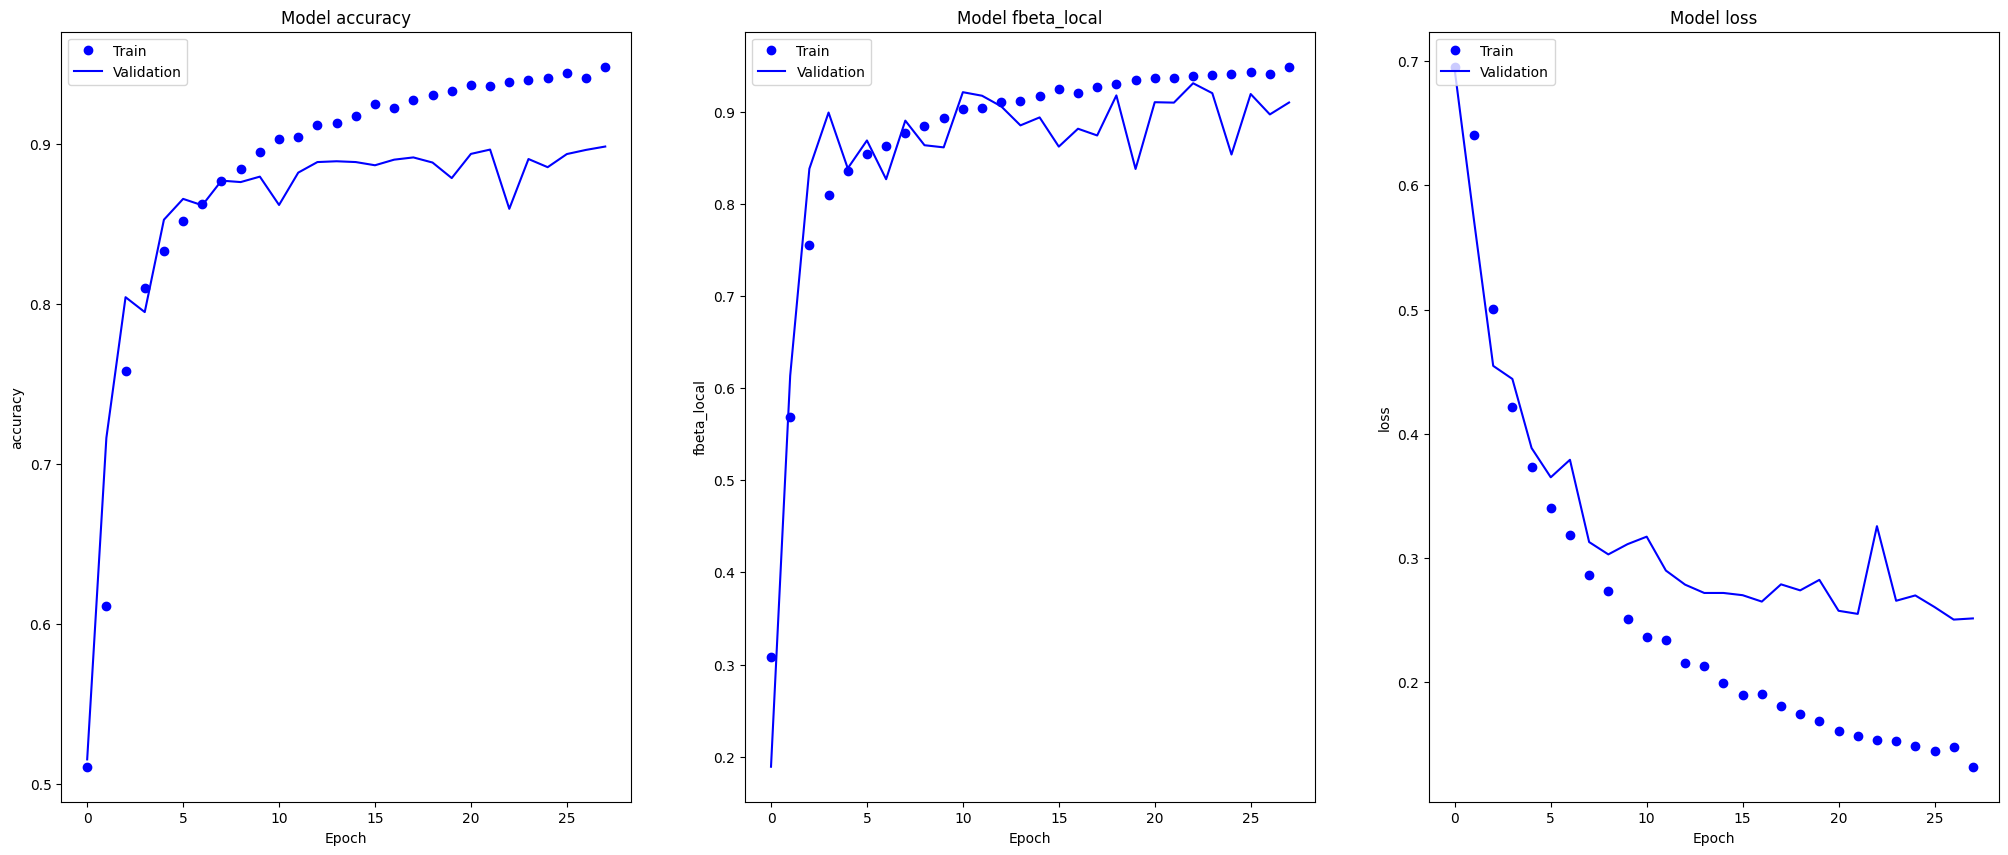

In [64]:
plot_results(
    'cnn_lab2',
    ['accuracy', 'fbeta_local', 'loss'],
    ['accuracy','val_accuracy','fbeta_local', 'val_fbeta_local', 'loss','val_loss'],
    cnn_histories_numberbatch_imdb
)

# Train BERT

In [22]:
print_gpu_usage()
print("Loading BERTS ...")
## Load tokenizer and the pre-trained bert model
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')
print("Done...")
print_gpu_usage()

GPU Peak Memory:  0.0 G
Instructions for updating:
Use tf.config.experimental.get_memory_info(device)['current'] instead.
GPU Current Memory Usage:  0.0 G
Loading BERTS ...


Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Done...
GPU Peak Memory:  0.5728297233581543 G
GPU Current Memory Usage:  0.41112565994262695 G


In [23]:
batch_size = 16
max_encoding_length = 512
bert_out_dimension = 768

In [24]:
def save_bottleneck(bert_model, tokenizer, ds, batch_size, max_length, filename_addendum, verbose=False):
    bottleneck_features = []
    labels_train = []
    
    batch_num = 1
    for i in range(0, ds.shape[0], batch_size):
        batch = ds.iloc[i:i+batch_size].review.tolist()
        inputs = tokenizer(
            text=batch,
            add_special_tokens=True,
            max_length=max_length,
            truncation=True,
            padding=True,
            return_tensors='tf',
            return_token_type_ids=False,
            return_attention_mask=True,
            verbose=True
        )
        
        out = bert_model(inputs)
        bottleneck_features.extend(out.pooler_output)
        labels_train.extend(ds.iloc[i:i+batch_size].sentiment)
        
        del out
        if verbose and batch_num % 500 == 0:
            print("Batch {} - size {}".format(batch_num, len(batch)))
            print_gpu_usage()
        batch_num = batch_num + 1
    
    print("Total Number of batches {} - Length of bottleneck features {}".format(batch_num, len(bottleneck_features)))
    bottleneck_features = np.array(bottleneck_features)
    labels_train = np.array(labels_train)
    data_filename = 'bottleneck_features_{}_{}.npy'.format(filename_addendum, max_length)
    labels_filename = 'bottleneck_labels_{}_{}.npy'.format(filename_addendum, max_length)
    np.save(data_filename, bottleneck_features)
    np.save(labels_filename, labels_train)
    
    return data_filename, labels_filename

In [25]:
df_train, df_test = train_test_split(
    df, 
    test_size=0.2,
    random_state=42
)

In [28]:
%%time
train_bottlenck_feature_file, train_labels_file = save_bottleneck(
    bert_model = bert,
    tokenizer= tokenizer,
    ds = df_train,
    batch_size = batch_size, 
    max_length = max_encoding_length,
    filename_addendum = 'train',
    verbose = True
)

Batch 500 - size 16
GPU Peak Memory:  1.6448190212249756 G
GPU Current Memory Usage:  0.43417906761169434 G
Batch 1000 - size 16
GPU Peak Memory:  1.6807687282562256 G
GPU Current Memory Usage:  0.45709776878356934 G
Batch 1500 - size 16
GPU Peak Memory:  1.7037484645843506 G
GPU Current Memory Usage:  0.48007750511169434 G
Batch 2000 - size 16
GPU Peak Memory:  1.7038476467132568 G
GPU Current Memory Usage:  0.5030629634857178 G
Batch 2500 - size 16
GPU Peak Memory:  1.7362611293792725 G
GPU Current Memory Usage:  0.5259530544281006 G
Total Number of batches 2501 - Length of bottleneck features 40000
CPU times: user 3min 48s, sys: 4.57 s, total: 3min 53s
Wall time: 3min 22s


In [29]:
%%time
test_bottlenck_feature_file, test_labels_file = save_bottleneck(
    bert_model = bert,
    tokenizer= tokenizer,
    ds = df_test,
    batch_size = batch_size, 
    max_length = max_encoding_length,
    filename_addendum = 'test',
    verbose = True
)

Batch 500 - size 16
GPU Peak Memory:  1.7362611293792725 G
GPU Current Memory Usage:  0.4340991973876953 G
Total Number of batches 626 - Length of bottleneck features 10000
CPU times: user 57.6 s, sys: 1.01 s, total: 58.6 s
Wall time: 51 s


In [31]:
def load_bottleneck(train_x_file, train_y_file, test_x_file, test_y_file):
    # Load bottleneck features that have already been extracted by base model
    train_data = np.load(train_x_file)
    train_labels = np.load(train_y_file)
    print('Training Data Shape: ',train_data.shape, 'Training Label Shape: ',train_labels.shape)

    test_data = np.load(test_x_file)
    test_labels = np.load(test_y_file)
    print('Val Data Shape: ',test_data.shape, 'Val Label Shape: ', test_labels.shape)
    return train_data, train_labels, test_data, test_labels

In [32]:
train_data, train_labels, test_data, test_labels = load_bottleneck(
    train_x_file = train_bottlenck_feature_file, 
    train_y_file = train_labels_file,
    test_x_file = test_bottlenck_feature_file, 
    test_y_file = test_labels_file
)

Training Data Shape:  (40000, 768) Training Label Shape:  (40000,)
Val Data Shape:  (10000, 768) Val Label Shape:  (10000,)


In [33]:
def get_top_model():
    sequence_input = Input(shape=(bert_out_dimension,))
    
    # x = layers.Dense(512, activation='relu')(sequence_input)
    # x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(sequence_input)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    preds = layers.Dense(1, activation='sigmoid')(x)

    top_model = Model(sequence_input, preds)
    # compile and add loss function. Cross entropy seems like a good choice
    # using the "binary_crossentropy" allows us to represent the output as 0 or 1
    top_model.compile(
        optimizer='adam',
        loss='binary_crossentropy', 
        metrics=[
            'accuracy',
            fbeta_local
        ]
    )

    return top_model

In [34]:
def train_top_on_bottleneck(
    model, 
    train_data, train_labels, 
    test_data, test_labels,
    epochs, batch_size, 
    histories
):
    checkpoint_filepath = 'model_checkpoint'
    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_accuracy',
        mode='max',
        save_best_only=True
    )

    print('Training transfer model from bottleneck...')
    history = model.fit(
        train_data, train_labels,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[model_checkpoint_callback],
        validation_data=(test_data, test_labels),
        verbose=1
    )
    
    histories.append(history)
    print_gpu_usage()


    # notice that the model gets accurate on the validation VERY quickly. 
    # So quickly, that we need to be careful not to over train. 

    top_model_weights_path = 'model_top_model_weights.h5'
    top_model.save_weights(top_model_weights_path)

    top_model.save('models_model_top_model_full')
    
    return top_model

In [35]:
top_model = get_top_model()
top_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 768)]             0         
                                                                 
 dense (Dense)               (None, 256)               196864    
                                                                 
 dropout_37 (Dropout)        (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_38 (Dropout)        (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 229,889
Trainable params: 229,889
Non-trainable

In [36]:
top_model_with_bottlenecks = []

In [99]:
%%time
train_top_on_bottleneck(
    model = top_model, 
    train_data = train_data,
    train_labels = train_labels, 
    test_data = test_data,
    test_labels = test_labels,
    epochs = 15, 
    batch_size = 64,
    histories = top_model_with_bottlenecks
)

Training transfer model from bottleneck...
Epoch 1/15
625/625 [==============================] - 20s 32ms/step - loss: 0.5028 - accuracy: 0.7653 - fbeta_local: 0.7271 - val_loss: 0.5087 - val_accuracy: 0.7620 - val_fbeta_local: 0.6147
Epoch 2/15
625/625 [==============================] - 20s 33ms/step - loss: 0.4982 - accuracy: 0.7677 - fbeta_local: 0.7324 - val_loss: 0.5102 - val_accuracy: 0.7780 - val_fbeta_local: 0.6686
Epoch 3/15
625/625 [==============================] - 20s 32ms/step - loss: 0.5065 - accuracy: 0.7623 - fbeta_local: 0.7240 - val_loss: 0.4852 - val_accuracy: 0.7830 - val_fbeta_local: 0.6977
Epoch 4/15
625/625 [==============================] - 21s 33ms/step - loss: 0.5000 - accuracy: 0.7669 - fbeta_local: 0.7314 - val_loss: 0.5142 - val_accuracy: 0.7710 - val_fbeta_local: 0.6429
Epoch 5/15
625/625 [==============================] - 21s 33ms/step - loss: 0.5034 - accuracy: 0.7665 - fbeta_local: 0.7271 - val_loss: 0.4785 - val_accuracy: 0.7920 - val_fbeta_local: 0.76

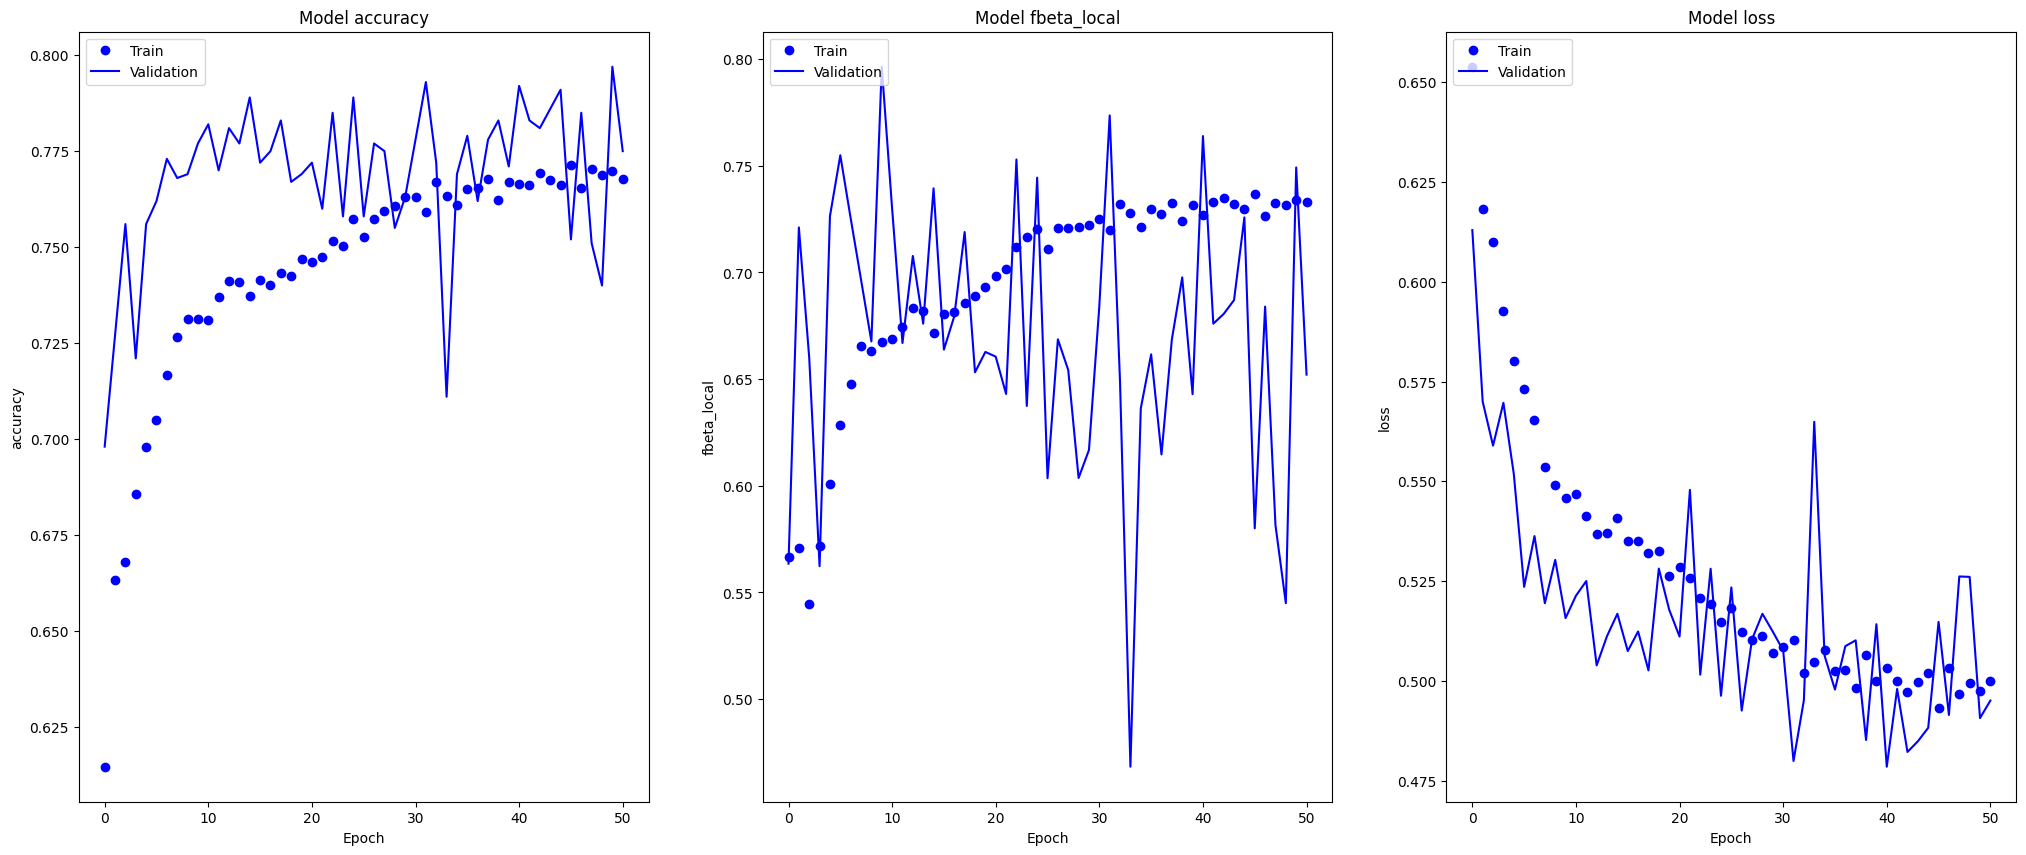

In [100]:
plot_results(
    'top_model', 
    ['accuracy', 'fbeta_local', 'loss'],
    ['accuracy','val_accuracy', 'fbeta_local', 'val_fbeta_local', 'loss','val_loss'],
    top_model_with_bottlenecks
)

In [58]:
def get_combined_model(bert_base_model, top_model, max_tokenization_len):
    in_id = tf.keras.layers.Input(shape=(max_tokenization_len,), name="input_ids", dtype='int32')
    in_mask = tf.keras.layers.Input(shape=(max_tokenization_len,), name="input_masks",dtype='int32')

    # bert_base_model.layers[0].embeddings.trainable = True
    
    # Hidden layer
    # embeddings = bert_base_model(input_ids, attention_mask = input_mask)[1] # 0 = last hidden state, 1 = poller_output
    
    for layer in bert_base_model.layers[:]:
        if isinstance(layer, transformers.models.bert.modeling_tf_bert.TFBertMainLayer):
            for encoder_layer in layer.encoder.layer:
                if encoder_layer.name == 'layer_._11':
                    print("Setting TRUE")
                    encoder_layer.trainable = True
                else:
                    encoder_layer.trainable = False
            layer.embeddings.trainable = False
            layer.pooler.trainable = False

    model = tf.keras.Model(
        inputs=[in_id, in_mask] , 
        outputs=top_model(bert({'input_ids':in_id, 'attention_mask':in_mask})[1])
    )
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9),
        metrics=[
            'accuracy',
            fbeta_local
        ]
    )
    
    return model

In [59]:
combined_model = get_combined_model(
    bert,
    top_model,
    max_encoding_length
)
combined_model.summary()

Setting TRUE
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_masks (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  108310272   ['input_masks[0][0]',            
                                thPoolingAndCrossAt               'input_ids[0][0]']              
                                tentions(last_hidde                                               
                                n_state=(None, 512,                            

In [ ]:
%%time
train_tokenized = tokenizer(
    text=df_train.review.tolist(),
    add_special_tokens=True,
    max_length=max_encoding_length,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

In [ ]:
%%time
test_tokenized = tokenizer(
    text=df_test.review.tolist(),
    add_special_tokens=True,
    max_length=max_encoding_length,
    truncation=True,
    padding=True,
    return_tensors='tf',
    return_token_type_ids=False,
    return_attention_mask=True,
    verbose=True
)

In [ ]:
%%time
checkpoint_filepath = 'models/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

print('Fine tuning combined model...')
history = combined_model.fit(
    x={'input_ids': train_tokenized['input_ids'],'input_masks':train_tokenized['attention_mask']},
    y = df_train['sentiment'], 
    epochs=1,
    batch_size=16,
    callbacks=[model_checkpoint_callback],
     validation_data = (
         {'input_ids':test_tokenized['input_ids'], 'input_masks':test_tokenized['attention_mask']},
         df_test['sentiment']
     ),
    verbose=1
)